EN3160 Assignment  2 on Fitting and Assignment 

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import skimage
from skimage.feature import blob_log

Range of sigma values used: 2 - 40
The maximum initial radius before adjustment: 36.0
The maximum adjusted radius: 50.91168824543143


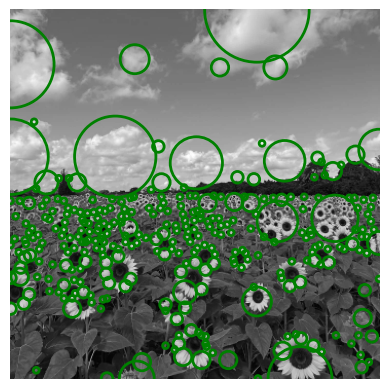

In [31]:
# Load the original image with reduced color resolution
image_original = cv.imread("Images/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
image_gray = cv.cvtColor(image_original, cv.COLOR_BGR2GRAY)

# Detect blobs using the Laplacian of Gaussian (LoG) method
blobs_log = blob_log(image_gray, min_sigma=2, max_sigma=40, num_sigma=20, threshold=0.1)

# Find the maximum radius of the detected blobs before adjustment
max_initial_radius = max(blobs_log[:, 2])

# Adjust the detected blobs' sizes by multiplying the radius by sqrt(2)
# This step adjusts the radii to more accurately reflect blob size
blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)

# Find the maximum radius after adjustment
max_adjusted_radius = max(blobs_log[:, 2])

# Create a figure and axis to display the grayscale image
fig, ax = plt.subplots()
ax.imshow(image_gray, cmap='gray')  # Display the grayscale image
ax.axis('off')  # Hide axis for better visualization

# Loop through each detected blob and draw a circle around it
for blob in blobs_log:
    y, x, radius = blob  # Extract blob coordinates and radius
    # Create a circular patch around each blob
    circle = plt.Circle((x, y), radius, color='green', linewidth=2, fill=False)
    ax.add_patch(circle)  # Add the circle to the plot

# Print information about sigma range and maximum blob radius
print('Range of sigma values used: 2 - 40')
print(f'The maximum initial radius before adjustment: {max_initial_radius}')
print(f'The maximum adjusted radius: {max_adjusted_radius}')

# Show the plot with detected blobs
plt.show()

Question 02

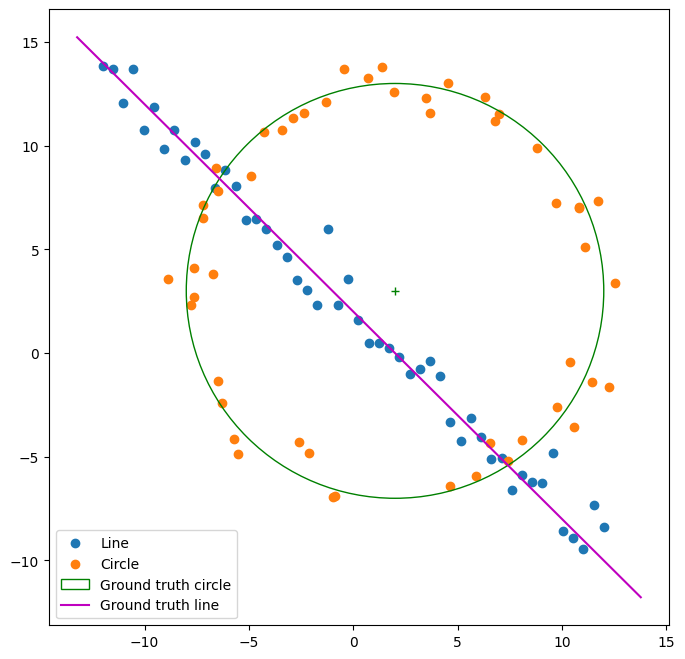

In [10]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
#import tikzplotlib
import numpy as np

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))  # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()

Best Line Parameters:
a = 0.6975714624178756
b = 0.7165152160423298
d = -1.3757979441764658
inliers = 34


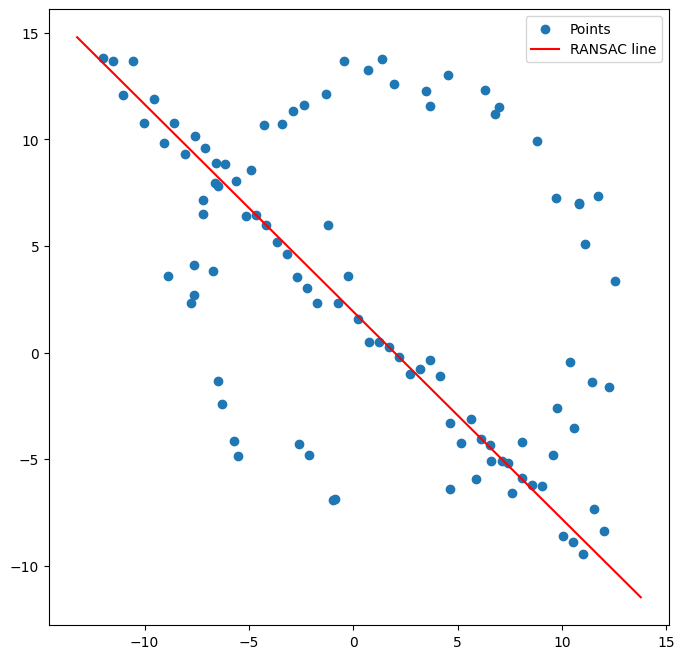

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute distance of points from a line
def compute_distances(points, a, b, d):
    # Using |a*x + b*y + d| since [a,b] is a unit vector (constraint ∥[a,b]∥=1)
    distances = np.abs(a * points[:, 0] + b * points[:, 1] + d)
    return distances

# Function to fit a line from two points
def fit_line_from_points(p1, p2):
    # The line through p1=(x1, y1) and p2=(x2, y2)
    # Ax + By + C = 0, where (A,B) is the normal vector to the line
    delta_x = p2[0] - p1[0]
    delta_y = p2[1] - p1[1]
    
    # Normal vector to the line (A,B) = (-delta_y, delta_x)
    a = -delta_y
    b = delta_x
    
    # Normalize [a, b] to satisfy ∥[a, b]∥=1
    norm = np.sqrt(a**2 + b**2)
    a /= norm
    b /= norm
    
    # Distance from the origin (perpendicular distance)
    d = -(a * p1[0] + b * p1[1])
    
    return a, b, d

# RANSAC algorithm
def ransac_line_fitting(points, num_iterations, distance_threshold, min_inliers):
    best_a, best_b, best_d = None, None, None
    best_inliers_count = 0
    n_points = points.shape[0]
    
    for _ in range(num_iterations):
        # Randomly sample two points
        random_indices = np.random.choice(n_points, 2, replace=False)
        p1, p2 = points[random_indices]
        
        # Fit a line using the two points
        a, b, d = fit_line_from_points(p1, p2)
        
        # Compute distances of all points from the line
        distances = compute_distances(points, a, b, d)
        
        # Identify inliers (points within the distance threshold)
        inliers = points[distances < distance_threshold]
        inliers_count = inliers.shape[0]
        
        # Update the best model if this one has more inliers
        if inliers_count > best_inliers_count and inliers_count >= min_inliers:
            best_a, best_b, best_d = a, b, d
            best_inliers_count = inliers_count
    
    return best_a, best_b, best_d, best_inliers_count

# Parameters for RANSAC
num_iterations = 1000
distance_threshold = 0.5  # Distance threshold to consider a point an inlier
min_inliers = 5  # Minimum number of inliers to accept the model

# Run RANSAC on the noisy points
best_a, best_b, best_d, best_inliers_count = ransac_line_fitting(X, num_iterations, distance_threshold, min_inliers)

print(f"Best Line Parameters:")
print(f"a = {best_a}")
print(f"b = {best_b}")
print(f"d = {best_d}")
print(f"inliers = {best_inliers_count}")


# Plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best line found by RANSAC
x_vals = np.array(ax.get_xlim())
y_vals = -(best_a * x_vals + best_d) / best_b
ax.plot(x_vals, y_vals, color='red', label='RANSAC line')

plt.legend()
plt.show()

Best Circle Parameters:
xc = 2.2407928371583825
yc = 2.683681873893913
r = 10.048883867004555
inliers = 28


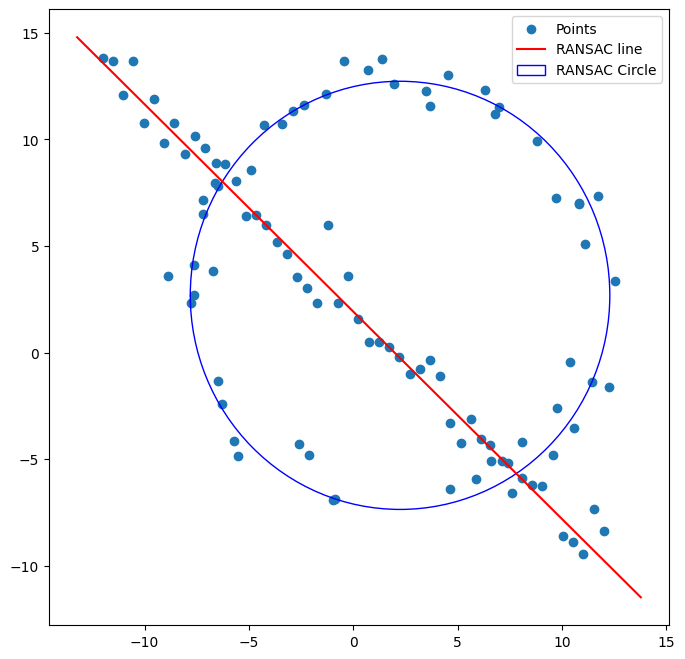

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the center and radius of a circle given 3 points
def circle_from_points(p1, p2, p3):
    # Using the equations of the perpendicular bisectors of the lines formed by p1-p2 and p2-p3
    A = np.array([[p2[0] - p1[0], p2[1] - p1[1]], [p3[0] - p2[0], p3[1] - p2[1]]])
    b = np.array([0.5 * (p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2), 0.5 * (p3[0]**2 - p2[0]**2 + p3[1]**2 - p2[1]**2)])
    center = np.linalg.solve(A, b)
    
    # Radius is the distance from the center to any of the points (we choose p1)
    radius = np.sqrt((center[0] - p1[0])**2 + (center[1] - p1[1])**2)
    
    return center[0], center[1], radius

# Function to compute radial distance of points from the circle
def radial_distances(points, xc, yc, r):
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    radial_error = np.abs(distances - r)
    return radial_error

# RANSAC algorithm for circle fitting
def ransac_circle_fitting(points, num_iterations, distance_threshold, min_inliers):
    best_xc, best_yc, best_r = None, None, None
    best_inliers_count = 0
    n_points = points.shape[0]
    
    for _ in range(num_iterations):
        # Randomly sample three points
        random_indices = np.random.choice(n_points, 3, replace=False)
        p1, p2, p3 = points[random_indices]
        
        # Fit a circle using the three points
        try:
            xc, yc, r = circle_from_points(p1, p2, p3)
        except np.linalg.LinAlgError:
            # Skip if the points are collinear and cannot define a circle
            continue
        
        # Compute radial distances of all points from the circle
        radial_error = radial_distances(points, xc, yc, r)
        
        # Identify inliers (points within the radial error threshold)
        inliers = points[radial_error < distance_threshold]
        inliers_count = inliers.shape[0]
        
        # Update the best model if this one has more inliers
        if inliers_count > best_inliers_count and inliers_count >= min_inliers:
            best_xc, best_yc, best_r = xc, yc, r
            best_inliers_count = inliers_count
            best_sample_points = [p1, p2, p3]

    return best_xc, best_yc, best_r, best_inliers_count, np.array(best_sample_points)


# Subtract the line inliers to get the remnant (circle points)
line_inliers = compute_distances(X, best_a, best_b, best_d) < distance_threshold
X_remnant = X[~line_inliers]

# Parameters for RANSAC circle fitting
circle_num_iterations = 1000
circle_distance_threshold = 0.5  # Radial error threshold to consider a point an inlier
circle_min_inliers = 20  # Minimum number of inliers to accept the circle model

# Run RANSAC for circle fitting on the remnant points
best_xc, best_yc, best_r, best_circle_inliers_count, best_sample_points = ransac_circle_fitting(X_remnant, circle_num_iterations, circle_distance_threshold, circle_min_inliers)
print("Best Circle Parameters:")
print(f"xc = {best_xc}")
print(f"yc = {best_yc}")
print(f"r = {best_r}")
print(f"inliers = {best_circle_inliers_count}")



# Plotting the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Points')

# Plot the best line found by RANSAC
x_vals = np.array(ax.get_xlim())
y_vals = -(best_a * x_vals + best_d) / best_b
ax.plot(x_vals, y_vals, color='red', label='RANSAC line')

# Plot the best circle found by RANSAC
circle_plot = plt.Circle((best_xc, best_yc), best_r, color='blue', fill=False, label='RANSAC Circle')
ax.add_patch(circle_plot)

plt.legend()
plt.show()

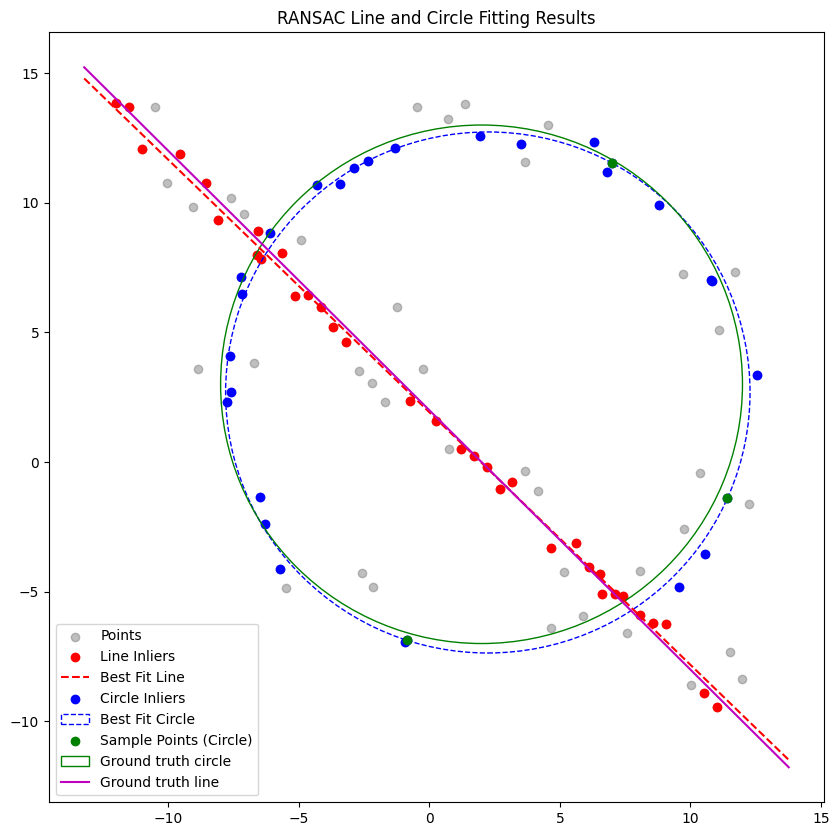

In [15]:
# Create the plot
def plot_ransac_results(X, best_a, best_b, best_d, best_xc, best_yc, best_r, best_sample_points, line_inliers, circle_inliers):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the point set
    ax.scatter(X[:, 0], X[:, 1], color='gray', label='Points', alpha=0.5)
    
    # Plot the line inliers
    ax.scatter(X[line_inliers, 0], X[line_inliers, 1], color='red', label='Line Inliers')
    
    # Plot the best estimate line
    x_vals = np.array(ax.get_xlim())
    y_vals = -(best_a * x_vals + best_d) / best_b
    ax.plot(x_vals, y_vals, 'r--', label='Best Fit Line')
    
    # Plot the circle inliers
    ax.scatter(X_remnant[circle_inliers, 0], X_remnant[circle_inliers, 1], color='blue', label='Circle Inliers')
    
    # Plot the best estimate circle
    circle_plot = plt.Circle((best_xc, best_yc), best_r, color='blue', fill=False, linestyle='--', label='Best Fit Circle')
    ax.add_patch(circle_plot)
    
    # Plot the three points that defined the circle
    ax.scatter(best_sample_points[:, 0], best_sample_points[:, 1], color='green', marker='o', label='Sample Points (Circle)', zorder=5)
    
    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    plt.title("RANSAC Line and Circle Fitting Results")
    plt.show()


# Find circle inliers based on the best circle
circle_inliers = radial_distances(X_remnant, best_xc, best_yc, best_r) < circle_distance_threshold

# Plot the final results
plot_ransac_results(X, best_a, best_b, best_d, best_xc, best_yc, best_r, best_sample_points, line_inliers, circle_inliers)

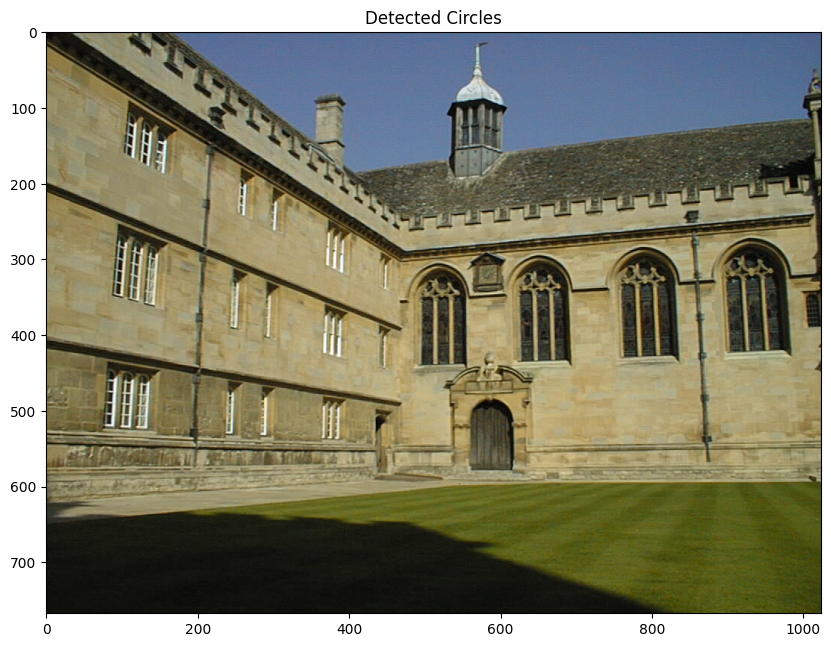

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img = cv2.imread("Images/005.jpg")
assert img is not None

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.grid(False)

# plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', color='white')

plt.show()

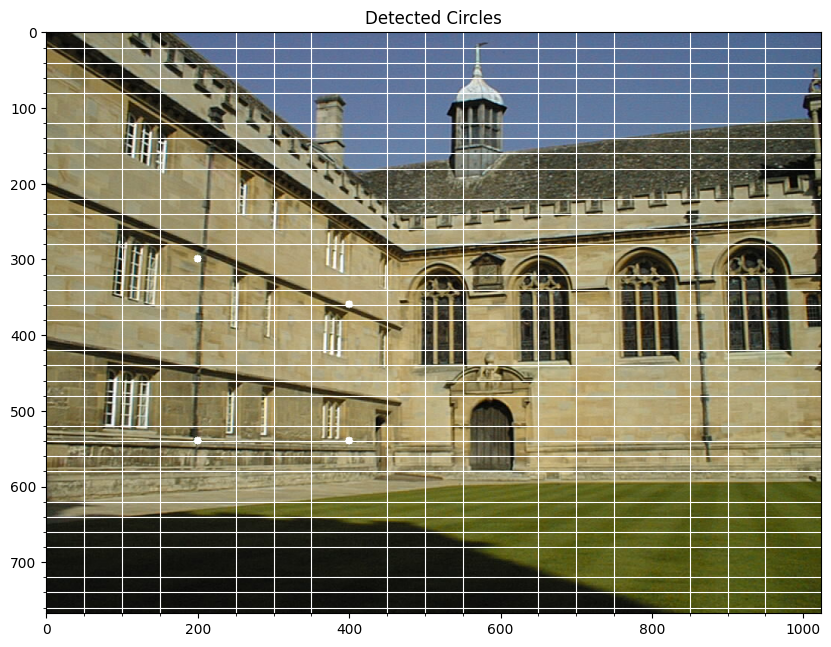

In [32]:
points_img = np.array([[200,300], [200,540], [400,360], [400,540]], dtype='float32')

img2 = img.copy()
# Specify the dot properties
color = (255, 255, 255)  # White color in BGR
radius = 5               # Radius of the dot
thickness = -1           # Thickness of the dot (filled)

# Draw dots on the image
for center_coordinates in points_img:
    # Draw the dot on the image
    cv2.circle(img2, (int(center_coordinates[0]), int(center_coordinates[1])), radius, color, thickness)

# Display the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
# plt.grid(True)

plt.minorticks_on()  # Enable minor ticks
plt.grid(which='minor', color='white')

plt.show()

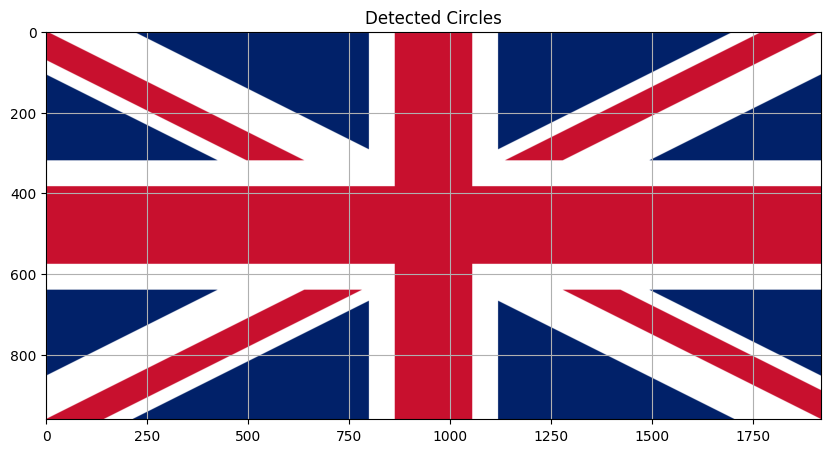

(960, 1920, 3)

In [18]:
flag_img = cv2.imread("Images/flag.png")
assert img is not None

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.grid(True)
plt.show()

flag_img.shape

In [39]:
points_img = np.array([[200,300], [200,540], [400,360], [400,540]], dtype='float32')
points_flag = np.array([[0, 0], [0,959], [1919,0], [1919,959]], dtype='float32')

def compute_homography(src_pts, dst_pts):

    assert src_pts.shape == dst_pts.shape, "Source and destination points must have the same shape."
    assert src_pts.shape[0] >= 4, "At least 4 point correspondences are needed to compute the homography."
    num_points = src_pts.shape[0]

    A = []
    for i in range(num_points):
        x_src, y_src = src_pts[i][0], src_pts[i][1]
        x_dst, y_dst = dst_pts[i][0], dst_pts[i][1]

        # Two rows per correspondence
        A.append([-x_src, -y_src, -1, 0, 0, 0, x_dst * x_src, x_dst * y_src, x_dst])
        A.append([0, 0, 0, -x_src, -y_src, -1, y_dst * x_src, y_dst * y_src, y_dst])

    A = np.array(A)

    AtA = np.dot(A.T, A)

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(AtA)
    # Get the eigenvector corresponding to the smallest eigenvalue
    smallest_eigenvalue_index = np.argmin(eigenvalues)
    h = eigenvectors[:, smallest_eigenvalue_index]

    # Reshape h into the 3x3 homography matrix
    H = h.reshape(3, 3)
    # Normalize H (if necessary, to make H[2,2] = 1)
    return H

H = compute_homography(points_flag, points_img)
print(H)

[[-4.81759449e-04  1.10129658e-10 -5.54697869e-01]
 [-2.60150120e-04 -6.94095153e-04 -8.32046754e-01]
 [-4.81759481e-07  3.18057044e-13 -2.77348920e-03]]


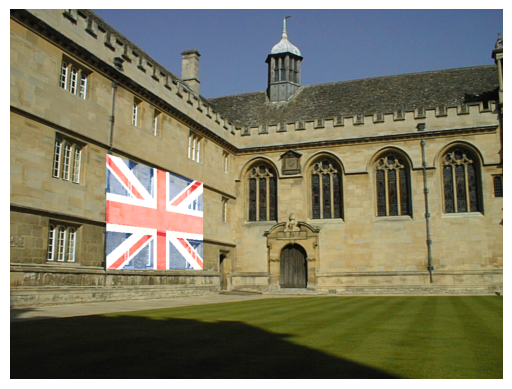

In [20]:
architecture = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
flag = cv2.cvtColor(flag_img, cv2.COLOR_BGR2RGB)

# Compute the homography

# Warp the flag image to fit the architectural plane
height, width, channels = architecture.shape
warped_flag = cv2.warpPerspective(flag, H, (width, height))

bg_img = np.ones((height, width, channels), dtype=np.uint8) * 255
# Blend the images
blended_image = cv2.addWeighted(warped_flag, 0.9, architecture , 1, 0)

plt.imshow(blended_image)
plt.axis('off')  # Hide axes
plt.show()

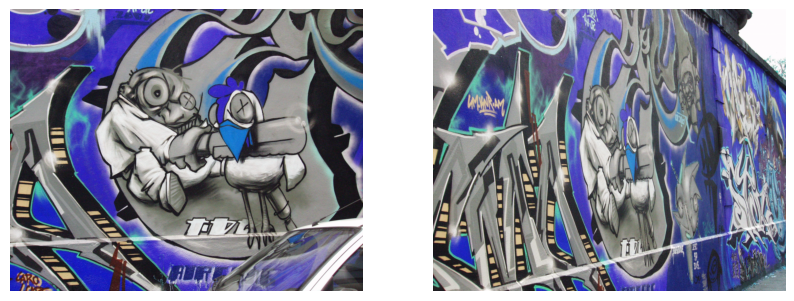

In [21]:
img1 = cv2.imread("Images/graf/graf/img1.ppm")
assert img1 is not None

img2 = cv2.imread("Images/graf/graf/img5.ppm")
assert img2 is not None

plt.figure(figsize = (10, 10))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off') 

plt.subplot(1,2,2)
plt.imshow(img2)
plt.axis('off')  # Hide axes

plt.show()

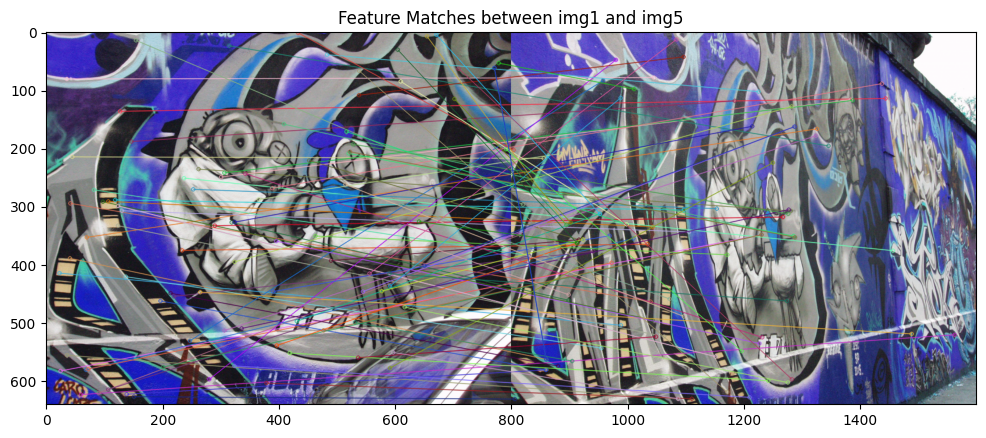

In [22]:
def find_matches(img1, img2):
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Use FLANN based matcher for feature matching
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Store only good matches based on Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    return kp1, des1, kp2, des2, good_matches

kp1, des1, kp2, des2, good_matches = find_matches(img1, img2)

img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches

plt.figure(figsize=(12, 8))
plt.imshow(img_matches)
plt.title('Feature Matches between img1 and img5')
plt.show()

In [23]:
import numpy as np
import random

def compute_homography(src_pts, dst_pts):
    """ Compute homography using four points. """
    num_points = src_pts.shape[0]

    A = []
    for i in range(num_points):
        x_src, y_src = src_pts[i][0], src_pts[i][1]
        x_dst, y_dst = dst_pts[i][0], dst_pts[i][1]

        A.append([-x_src, -y_src, -1, 0, 0, 0, x_dst * x_src, x_dst * y_src, x_dst])
        A.append([0, 0, 0, -x_src, -y_src, -1, y_dst * x_src, y_dst * y_src, y_dst])

    A = np.array(A)

    # SVD to solve for H (Ax=0)
    U, S, Vt = np.linalg.svd(A)
    H = Vt[-1, :].reshape(3, 3)

    # Normalize H to ensure H[2,2] is 1
    H = H / H[-1, -1]
    return H


def apply_homography(H, point):
    """ Apply homography to a point. """
    homogeneous_point = np.array([point[0], point[1], 1.0])
    transformed_point = np.dot(H, homogeneous_point)
    
    # Convert back from homogeneous coordinates to (x, y)
    x, y = transformed_point[0] / transformed_point[2], transformed_point[1] / transformed_point[2]
    return np.array([x, y])


def compute_ransac_homography(src_pts, dst_pts, num_iterations=1000, threshold=5.0):
    """ Compute homography using RANSAC algorithm. """
    max_inliers = 0
    best_H = None

    for k in range(num_iterations):
        # Randomly sample 4 points for computing homography
        indices = random.sample(range(len(src_pts)), 4)
        sampled_src_pts = src_pts[indices]
        sampled_dst_pts = dst_pts[indices]

        # Compute homography using 4 random points
        H = compute_homography(sampled_src_pts, sampled_dst_pts)

        # Count the number of inliers
        inliers = 0
        for i in range(len(src_pts)):
            transformed_point = apply_homography(H, src_pts[i])
            error = np.linalg.norm(transformed_point - dst_pts[i])
            if error < threshold:
                inliers += 1

        # Update best homography if more inliers are found
        if inliers > max_inliers:
            max_inliers = inliers
            best_H = H

    # Refine homography using inliers (optional)
    inlier_src_pts = []
    inlier_dst_pts = []
    for i in range(len(src_pts)):
        transformed_point = apply_homography(best_H, src_pts[i])
        error = np.linalg.norm(transformed_point - dst_pts[i])
        if error < threshold:
            inlier_src_pts.append(src_pts[i])
            inlier_dst_pts.append(dst_pts[i])

    if len(inlier_src_pts) >= 4:
        best_H = compute_homography(np.array(inlier_src_pts), np.array(inlier_dst_pts))

    return best_H, max_inliers

In [24]:
img1 = cv2.imread("Images/graf/graf/img1.ppm")
assert img1 is not None

img2 = cv2.imread("Images/graf/graf/img2.ppm")
assert img2 is not None

img3 = cv2.imread("Images/graf/graf/img3.ppm")
assert img1 is not None

img4 = cv2.imread("Images/graf/graf/img4.ppm")
assert img2 is not None

img5 = cv2.imread("Images/graf/graf/img5.ppm")
assert img1 is not None

imgs = [img1, img2 , img3, img4, img5]

srs_pts_list = []
dst_pts_list = []

for i in range(len(imgs)-1):
    kp1, des1, kp2, des2, good_matches = find_matches(imgs[i], imgs[i+1])
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    srs_pts_list.append(src_pts)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts_list.append(dst_pts)

Hs = []

for i in range(len(srs_pts_list)):
    H, _ = compute_ransac_homography(srs_pts_list[i], dst_pts_list[i])
    Hs.append(H)

print(Hs)

[array([[ 8.79894268e-01,  3.14215943e-01, -3.98763439e+01],
       [-1.82684908e-01,  9.34938587e-01,  1.53752096e+02],
       [ 1.98182440e-04, -1.91541273e-05,  1.00000000e+00]]), array([[ 6.72534145e-01, -5.30673152e-01,  3.30011403e+02],
       [ 5.98170659e-01,  8.65272984e-01, -1.85524488e+02],
       [ 1.58875342e-04, -5.21483149e-05,  1.00000000e+00]]), array([[ 5.61141092e-01,  8.49861431e-01, -9.36098785e+01],
       [-6.99420715e-01,  7.72893251e-01,  3.70226518e+02],
       [ 1.07925628e-04,  2.60359406e-05,  1.00000000e+00]]), array([[ 6.46054579e-01, -3.91672548e-01,  2.98273666e+02],
       [ 5.72392273e-01,  7.70557548e-01, -1.20306760e+02],
       [ 6.70737438e-05, -8.17602334e-05,  1.00000000e+00]])]


In [25]:
final_homograph = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
final_homograph = (1/final_homograph.item(8))*final_homograph
final_homograph

print('Mt Homography\n',final_homograph)


Mt Homography
 [[ 6.25072012e-01  5.82824869e-02  2.21779863e+02]
 [ 2.23903897e-01  1.15260412e+00 -2.38652433e+01]
 [ 4.97740896e-04 -5.68996902e-05  1.00000000e+00]]


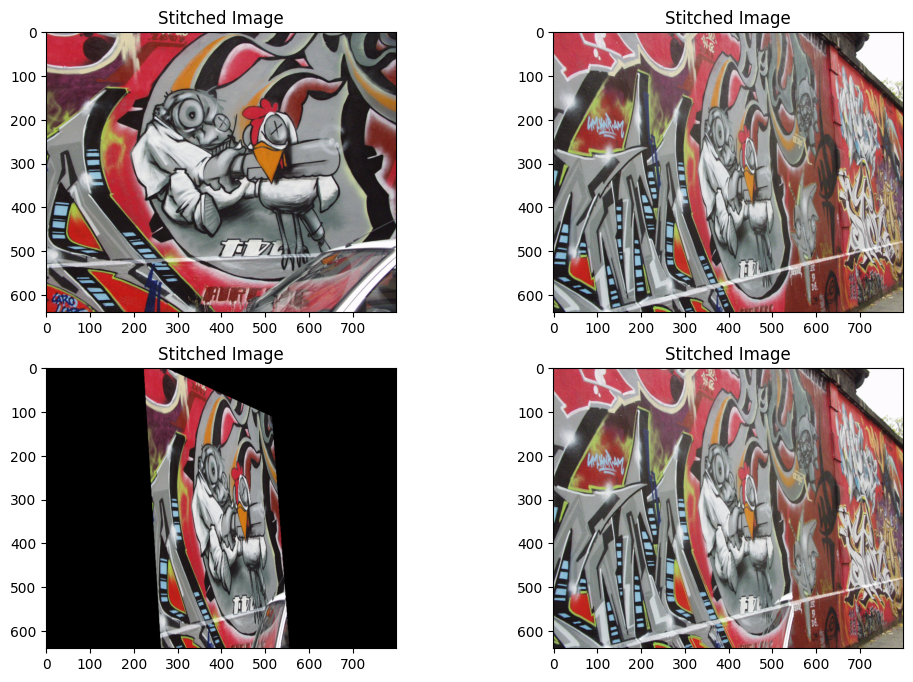

In [28]:
img1_color = cv2.imread('Images/graf/graf/img1.ppm')
img5_color = cv2.imread('Images/graf/graf/img5.ppm')

# Get dimensions of the first image (img1)
h1, w1 = img1_color.shape[:2]

# Get dimensions of the second image (img5)
h5, w5 = img5_color.shape[:2]

# Warp img1 to img5 using the homography matrix H
warped_img1 = cv2.warpPerspective(img1_color, final_homograph, (w5, h5))

# Create a white canvas for the stitched result
stitched_image = np.zeros_like(img5_color)

# Place img5 on the canvas
stitched_image[0:h5, 0:w5] = img5_color

# Overlay warped img1 onto the stitched result
# Use max to take the non-black pixels from warped_img1
stitched_image = np.maximum(stitched_image, warped_img1)

# Display the stitched image
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img5_color, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')

plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(warped_img1 , cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')

plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.title('Stitched Image')
plt.show()